# **Imports**

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
vedios_folder = '/content/gdrive/MyDrive/Team/vision/assignment5'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Load** **Vedios**

In [ ]:
car_path=vedios_folder+'/car2.npy'
car_video = np.load(car_path)
print(car_video.shape)

(240, 320, 415)


In [ ]:
helicopter_path=vedios_folder+'/landing.npy'
helicopter_vedio=np.load(helicopter_path)
print(helicopter_vedio.shape)

(1000, 1100, 50)


In [ ]:
def crop_image(image,rect):
  cropped = image[rect[1]:rect[3], rect[0]:rect[2]]
  return cropped

# **Car**

In [ ]:
def LucasKanade(image,template,rect,p,threshold,iterations,width,height):
  rows,cols = template.shape
  norm = np.inf

  W=0

  sobel_x = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
  sobel_y = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)

  for iteration in range(iterations):
      W = np.array([[1+p[0], p[2], p[4]], [p[1], 1+p[3], p[5]]])

      updatedRect=get_updated_rectangle(W,rect,width,height,image)

      warpedImage = cv2.warpAffine(image,W,dsize=(image.shape[1],image.shape[0]))
      currentFrame = crop_image(warpedImage,updatedRect)
      currentFrameHeight , currentFrameWeight = currentFrame.shape

      tempRect = np.array([0,0,currentFrameWeight,currentFrameHeight])
      error = crop_image(template,tempRect).astype(int) - currentFrame.astype(int)


      steepest_descents = descents(updatedRect,sobel_x,sobel_y)
      Hessian = np.matmul(np.transpose(np.array(steepest_descents)),np.array(steepest_descents))
      Hessian_inv = np.linalg.pinv(Hessian)


      dP = np.matmul(np.matmul(Hessian_inv,np.transpose(np.array(steepest_descents))),error.reshape(((error.shape[0]*error.shape[1]),1)))
      p += dP.reshape((-1))
      norm = np.linalg.norm(dP)


      if norm <= threshold:
              break

  topLeftX , topLeftY , bottomRightX , bottomRightY = get_final_rectangle_borders(W,rect,width,height,image)

  return p,topLeftX , topLeftY , bottomRightX , bottomRightY


In [ ]:
def descents(updatedRect,sobel_x,sobel_y):
    steepest_descents = []
    for i in range(updatedRect[1],updatedRect[3]):
      for j in range(updatedRect[0],updatedRect[2]):
        dI = np.array([sobel_x[i][j], sobel_y[i][j]])
        jacobian = np.array([[j,0,i,0,1,0],[0,j,0,i,0,1]])
        matrix = np.matmul(dI, jacobian)
        steepest_descents.append(matrix)
    return steepest_descents

In [ ]:
def get_updated_rectangle(W,rect,width,height,image):
    topLeft = np.array([[rect[0]],[rect[1]],[1]])
    updatedTopLeft = W @ topLeft
    topLeftX,topLeftY = max(0, updatedTopLeft[0][0]), max(0, updatedTopLeft[1][0])
    
    bottomRightX,bottomRightY = min(image.shape[1], topLeftX+width), min(image.shape[0], topLeftY+height)

    updatedRect = [int(topLeftX), int(topLeftY), int(bottomRightX), int(bottomRightY)] 
    return updatedRect

In [ ]:
def get_final_rectangle_borders(W,rect,width,height,image):
    updatedRect = get_updated_rectangle(W,rect,width,height,image)
    return updatedRect[0] , updatedRect[1] , updatedRect[2] , updatedRect[3]

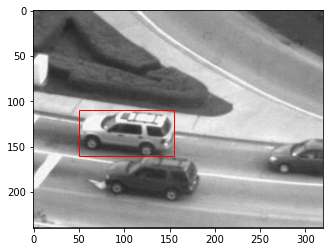

In [ ]:
#Get First frame
first_frame = car_video[:,:,0]
fig, ax = plt.subplots()
ax.imshow(first_frame, cmap='gray')
rect = patches.Rectangle((50, 110), 105, 50, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

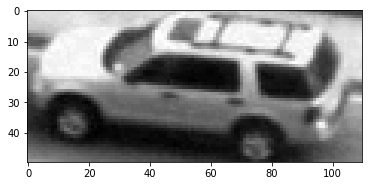

In [ ]:
#Get template and rectangle to use
rect_car = np.array([50,110,160,160])
template = crop_image(first_frame,rect_car)
plt.imshow(template, cmap='gray')
plt.show()

In [ ]:
for i in range(415):
  p = np.zeros(6)
  current_frame = car_video[:,:,i].copy()
  p, TopLeftX,TopLeftY, BottomRightX, BottomRightY = LucasKanade(current_frame, template, rect_car, p, 0.001, 200,110,50)
  rect_car = [int(TopLeftX), int(TopLeftY), int(BottomRightX), int(BottomRightY)]
  image = cv2.rectangle(current_frame,(int(TopLeftX),int(TopLeftY)), (int(BottomRightX), int(BottomRightY)), (0, 0, 0), 2)
  print(i)
  cv2_imshow(image)

In [ ]:
h, w = car_video[:,:,0].shape
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(vedios_folder + '/result.mp4', fourcc, 25.0, (w, h))
total_frames = car_video.shape[2]


for i in tqdm(range(total_frames)):
  p = np.zeros(6)
  current_frame = car_video[:,:,i].copy()
  p, topLeftX, topLeftY, bottomRightX, bottomRightY = LucasKanade(current_frame, template, rect_car, p, 0.001, 200,110,50)

  rect_car = [int(topLeftX), int(topLeftY), int(bottomRightX), int(bottomRightY)]

  output_frame = cv2.rectangle(current_frame,(int(topLeftX),int(topLeftY)), (int(bottomRightX), int(bottomRightY)), (0, 0, 0), 2)
  output_frame = cv2.cvtColor(output_frame,cv2.COLOR_GRAY2RGB)
  out.write(output_frame)

out.release()

100%|██████████| 415/415 [1:50:42<00:00, 16.01s/it]


# **Helicopter**

In [ ]:
def get_updated_rectangle_helicopter(W,rect,image):
  topLeft = np.array([[rect[0]],[rect[1]],[1]])
  updatedTopLeft = W @ topLeft
  topLeftX, topLeftY = max(0, updatedTopLeft[0][0]), max(0, updatedTopLeft[1][0]);

  bottomRight = np.array([[rect[2]],[rect[3]],[1]])
  updatedBottomRight = W @ bottomRight
  bottomRightX, bottomRightY = min(image.shape[1], updatedBottomRight[0][0]), min(image.shape[0], updatedBottomRight[1][0]);
        
  
  updatedRect = [int(topLeftX), int(topLeftY), int(bottomRightX), int(bottomRightY)]

  return updatedRect

In [ ]:
def get_final_rectangle_borders_helicopter(W,rect,image):
    updatedRect = get_updated_rectangle_helicopter(W,rect,image)
    return updatedRect[0] , updatedRect[1] , updatedRect[2] , updatedRect[3]

In [ ]:
def get_jacobian_matrix(width, height):
    x = np.array(range(width))
    y = np.array(range(height))
    x, y = np.meshgrid(x, y) 
    ones = np.ones((height, width))
    zeros = np.zeros((height, width))

    row1 = np.stack((x, zeros, y, zeros, ones, zeros), axis=2)
    row2 = np.stack((zeros, x, zeros, y, zeros, ones), axis=2)
    jacob = np.stack((row1, row2), axis=2)

    return jacob

In [ ]:
def LucasKanadeHelicopter(image,template,rect,p,threshold,iterations):
  norm = np.inf
  templateHeight , templateWidth = template.shape
  W=0
  for iteration in range(iterations):
    W = np.array([[1+p[0], p[2], p[4]], [p[1], 1+p[3], p[5]]])
    updatedRect = get_updated_rectangle_helicopter(W,rect,image)

    currentFrame = crop_image(image,updatedRect)

    error = template.astype(int) - cv2.resize(currentFrame, (templateWidth, templateHeight)).astype(int)

    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

    sobelX_Cropped = cv2.resize(crop_image(sobel_x, updatedRect),(templateWidth, templateHeight))
    sobelY_Cropped = cv2.resize(crop_image(sobel_y, updatedRect),(templateWidth, templateHeight))
           
    jacob = get_jacobian_matrix(templateWidth, templateHeight)
        
    gradient = np.stack((sobelX_Cropped, sobelY_Cropped), axis=2)
    gradient = np.expand_dims((gradient), axis=2)  
    steepestDescents = np.matmul(gradient, jacob)
    steepestDescentsTranspose = np.transpose(steepestDescents, (0, 1, 3, 2))
        
    Hessian = np.matmul(steepestDescentsTranspose, steepestDescents).sum((0,1))

    error = error.reshape((templateHeight, templateWidth, 1, 1))
    update = (steepestDescentsTranspose * error).sum((0,1))
        
    dP = np.matmul(np.linalg.pinv(Hessian), update).reshape((-1))   
    p += dP
    norm = np.linalg.norm(dP)

    if norm <= threshold:
        break
  topLeftX,topLeftY,bottomRightX,bottomRightY = get_final_rectangle_borders_helicopter(W,rect,image)
  return p, topLeftX, topLeftY, bottomRightX, bottomRightY


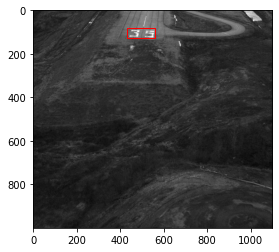

In [ ]:
#Get First frame
first_frame_helicopter = helicopter_vedio[:,:,0].copy()
fig, ax = plt.subplots()
ax.imshow(first_frame_helicopter, cmap='gray')
rect = patches.Rectangle((430, 80), 130, 45, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

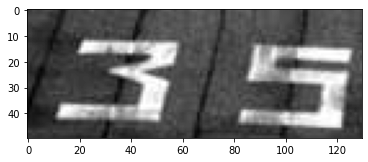

In [ ]:
#Get template and rectangle to use
rect_helicopter = np.array([430,80,560,130])
template_helicopter = crop_image(first_frame_helicopter,rect_helicopter)
plt.imshow(template_helicopter, cmap='gray')
plt.show()

In [ ]:
p = np.zeros(6)
for i in range(50):
  current_frame = helicopter_vedio[:,:,i].copy()
  p, TopLeftX,TopLeftY, BottomRightX, BottomRightY = LucasKanadeHelicopter(current_frame, template_helicopter, rect_helicopter, p, 0.001, 200)

  image = cv2.rectangle(current_frame,(int(TopLeftX),int(TopLeftY)), (int(BottomRightX), int(BottomRightY)), (0, 0, 0), 2)
  print(i)
  cv2_imshow(image[0:200, 200:800])

In [ ]:
height, width = helicopter_vedio[:,:,0].shape
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(vedios_folder + '/result_helicopter.mp4', fourcc, 15.0, (width, height))

total_frames = helicopter_vedio.shape[2]

p = np.zeros(6)

for i in tqdm(range(total_frames)):
  current_frame = helicopter_vedio[:,:,i].copy()
  p, topLeftX, topLeftY, bottomRightX, bottomRightY = LucasKanadeHelicopter(current_frame, template_helicopter, rect_helicopter, p, 0.001, 200)

  output_frame = cv2.rectangle(current_frame,(int(topLeftX),int(topLeftY)), (int(bottomRightX), int(bottomRightY)), (0, 0, 0), 2)
  output_frame = cv2.cvtColor(output_frame, cv2.COLOR_GRAY2RGB)
  out.write(output_frame)

out.release()

100%|██████████| 50/50 [02:21<00:00,  2.83s/it]
